## Installs

In [ ]:
!git clone https://github.com/m3-learning/DeepMatter.git
import os
# os.environ['CUDA_VISIBLE_DEVICES']='1'

In [ ]:
!pip install DeepMatter

## Imports

In [1]:
# import DeepMatter as dm
# from DeepMatter.spectral_fitters.gaussian import Gaussian
# # from DeepMatter.spectral_fitters.voigt import PseudoVoigt
# from DeepMatter.spectral_fitters import nn
# from DeepMatter.rand_util.rand_gen import rand_tensor
# # from DeepMatter.spectral_fitters.nn import DensePhysEnc9185

from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch
import numpy as np
import matplotlib.pyplot as plt


import time
import math
# from DeepMatter.util.torch_util import Dataset_Generator

from pdb import set_trace as bp
from tqdm import tqdm as tqdm
from datetime import date

from ipywidgets import interact
torch.set_default_dtype(torch.float32)

## utils

In [2]:
def rand_tensor(min=0, max=1, size=(1)):
    """ Function that generates random tensor between a range of an arbitary size

    :param min:  sets the minimum value of parameter
    :type min: float
    :param max:  sets the maximum value of parameter
    :type max: float
    :param size: sets the size of the random vector to generate
    :type size: tuple
    :return: random tensor generated
    :rtype: tensor
    """

    out = (max - min) * torch.rand(size,dtype=torch.float32) + min
    return out.type(torch.FloatTensor)

In [3]:
class Dataset_Generator(Dataset):
    """
    Function that generates data
    """

    def __init__(self,
                 model,
                 samples_per_epoch=10000,
                 size=1,
                 batch_size=32,
                 **kwargs):
        self.model = model
        self.samples_per_epoch = samples_per_epoch
        self.sd = kwargs.get('sd')
        self.mean = kwargs.get('mean')
        self.amp = kwargs.get('amp')
        self.fraction = kwargs.get('fraction')
        self.x_vector = kwargs.get('x_vector') # always assume a square
        self.size = size
        self.batch_size = batch_size
        self.noise = kwargs.get('noise')
        self.verbose = kwargs.get('verbose')
        self.function = self.model(self.x_vector,
                                   sd=self.sd,
                                   mean=self.mean,
                                   amp=self.amp,
                                   size=self.size)

    def __len__(self):
        return self.samples_per_epoch

    def __getitem__(self, idx):
        self.function.batch_size=self.batch_size
        input_, params = self.function.sampler(device='cuda')
        
        if self.noise is not None:
            # if self.verbose is True and not None:
                # print("adding noise\n")
            input_ += np.random.uniform(0, self.noise, size=input_.shape)
        return {'input': input_, 'params': params}

In [4]:
def imshow_tensor(tensor):
    '''
    tensor: a tensor to plot
    indices: shape tensor[:,d,:,v] give you the values to plot
    '''
    plt.imshow(tensor.T.cpu().detach().numpy())
    plt.show()

## pseudovoigt
* NOTE: This function is called pseudovoigt, but is only the gaussian portion for now. The lorentz portion will come later

* The voigt function is a probability distribution given by a convolution of a Cauchy-Lorentz distribution and a Gaussian distribution. It is often used in analyzing data from spectroscopy or diffraction. 
* ${\displaystyle V(x;\sigma ,\gamma )\equiv \int _{-\infty }^{\infty }G(x';\sigma )L(x-x';\gamma )\,dx',}$ where
  * ${\displaystyle G(x;\sigma )\equiv {\frac {e^{-x^{2}/(2\sigma ^{2})}}{\sigma {\sqrt {2\pi }}}},}$ and 
  * ${\displaystyle L(x;\gamma )\equiv {\frac {\gamma }{\pi (x^{2}+\gamma ^{2})}}.}$
  
  
* we are implementing the pseudovoigt approximation, which uses a linear combination of the gaussian and lorentzan, instead of the convolution. This is much faster to calculate
* The model is based off of the methods found [here](https://docs.mantidproject.org/nightly/fitting/fitfunctions/PseudoVoigt.html)


In [1]:
class PseudoVoigt_2D:
    """
    Class that computes the voigt (distribution) of a batch of data
    """

    def __init__(self, x_vector,
                 sd=[[0,1],[0,1]],
                 mean=[[0,1],[0,1]],
                 amp=[[0,1],[0,1]],
                 fraction=[[0,1],[0,1]],
                 size=(1, 1),
                 verbose=False):
        """

        Args:
            x_vector (Torch): 1D tensor to use for making meshgrid
            sd (array, float): x,y ranges for the standard deviation
            mean (array, float): ranges for the mean
            amp (array, float): ranges for the amplitude
            size (tuple): Size of the array first index is number of channels, second is number of functions
            verbose (bool): shows outputs
            
        """

        self.x_vector = x_vector
        num_params = 4 * 3 # 12 because the x-y axis are not correlated. will implement different sd function in future
        
        self.sd = sd # fwhm/2 of profile
        self.sd_mean = torch.sum(torch.tensor(sd),dim=0) / 2
        self.sd_sd = torch.sqrt((torch.pow(torch.tensor(sd[:][1]) - torch.tensor(sd[:][0]), 2) / num_params)) # 12 bc 3humps * 4params 
        # bp()
        self.mean = mean
        self.mean_mean = torch.sum(torch.tensor(mean),dim=0) / 2
        self.mean_sd = torch.sqrt((torch.pow(torch.tensor(mean[:][1]) - torch.tensor(mean[:][0]), 2) / num_params))
        
        self.amp = amp
        self.amp_mean = torch.sum(torch.tensor(amp),dim=0) / 2
        self.amp_sd = torch.sqrt((torch.pow(torch.tensor(amp[:][1]) - torch.tensor(amp[:][0]), 2) / num_params))
        
        self.fraction = fraction # (1-eta), which determines if peak is more gaussian (0) or more lorentzian (1)
        self.fraction_mean = torch.sum(torch.tensor(fraction),dim=0) / 2
        self.fraction_sd = torch.sqrt((torch.pow(torch.tensor(fraction[:][1]) - torch.tensor(fraction[:][0]), 2) / num_params))
        
        self.size = size
        self.verbose = verbose
        self.x,self.y = torch.meshgrid(x_vector,x_vector)
        self.dst = torch.sqrt(self.x**2+self.y**2)

        # bp()
        
        
    def gauss_pdf_2D(self,x,y,mean,sd,amp):
        '''
        x,y: from torch.meshgrid
        mean: [mx,my]
        sd: [sx,sy]
        '''
        
        mx=mean[:,0].reshape(-1,1,1)
        my=mean[:,1].reshape(-1,1,1)
        sx=sd[:,0].reshape(-1,1,1)
        sy=sd[:,1].reshape(-1,1,1)
        pi_ = torch.tensor(math.pi).reshape(-1,1,1)
        
        distr = amp*torch.exp(-((x - mx)**2 / (2*sx**2) + (y - my)**2 / (2*sy**2)))
        # bp()
        return distr
        
    def compute(self, params, device='cpu', noise=0):
        """
        Computes an image whose values are the sum of gaussian density functions
        Args:
            self (object): Returns the instance itself.
            params: for computation --> shape (1,1,2,4,3) #ch, bsize, dims, # par, # humps
            device (string, optional) : Sets the device to do the computation. Default `cpu`, common option `cuda`

        Returns: (sum(out), out) (list of Tensor): spectra added together

        """

        if self.verbose:
            print({f'pre-param size {params.size()}'})

        if len(params.size()) == 2:
            print('look')
            params = torch.reshape(params, (params.shape[0], 4, -1))

        if self.verbose:
            print(f'parm size = {params.size()}')
            print(f'x_vector size = {self.x_vector.shape[0]}')

        # out.shape = (bsize, xlen ,ylen , #ch, #humps)
        out = torch.zeros((params.shape[0],
                           self.x_vector.shape[0],
                           self.x_vector.shape[0],
                           self.size[0],
                           self.size[1]))
        if self.verbose:
            print(self.size[1])
        # params.shape = [1, 2, 4, 3] (bsize,dims,params,humps)
        params = params.to(device)
        
        x,y = self.x.to(device),self.y.to(device)
        x,y = x.repeat(params.shape[0],1,1),y.repeat(params.shape[0],1,1)
        # bp()
        # Get parameters
        for i in range(self.size[1]):
            if params.ndim == 5: # if it's a whole batch
                _mean = params[:,0,:, 0, i] 
                _sd = params[:, 0,:, 1, i] 
                _amp = params[:, 0,:, 2, i]  
                # _fraction = params[:, 0,:,3, i] 

            if params.ndim == 4: # if its a single value
                _mean = params[:,:, 0, i] 
                _sd = params[:, :, 1, i] 
                _amp = params[:,:,2, i]  
                # _fraction = params[:, :,3, i] 
                
            # x_vector = torch.cat(params.shape[0] * [self.x_vector]).reshape(params.shape[0],2,-1).to(device) # (ch,dims,12params)
            # x_vector = torch.transpose(x_vector,0,1)
            # x_vector = torch.transpose(x_vector,1,2)
            # (dims,12params,ch)
            
            if self.verbose:
                print(f'x_vector_shape = {x_vector.size()}')
            
            # Get gaussian distribution
            # bp()
            _out = self.gauss_pdf_2D(x,y,_mean,_sd,_amp[0,0])

            if self.verbose:
                print(f'amp {_amp.size()}, base {_base.size()}, exp {_exp.size()}')
                print(f'out shape = {_out.shape}')
            # bp()
    
            out[:,:,:,0, i] = _out
        out = torch.transpose(out,1,3).type(torch.FloatTensor)
        # out.shape = (bsize, xlen ,ylen , #ch, #humps)
        
        return torch.sum(out, dim=-1).squeeze(dim=0)
    
 
    def sampler(self,device='cpu',noise=0):
        """
        Samples parameters given a range of values
        
        Args:
            device (str): device where computation happens

        Returns:
            out (Tensor) : Generated spectra
            params (Tensor) : parameters used for generation

        """

        # Shape (2,1,3) --> (x/y, #ch, 3humps)
        sd = torch.stack([   rand_tensor(min=self.sd[0][0], max=self.sd[0][1], 
                             size=(self.size[0],self.size[1])),
                             rand_tensor(min=self.sd[1][0], max=self.sd[1][1], 
                             size=(self.size[0],self.size[1])) ])
        
        mean = torch.stack([ rand_tensor(min=self.mean[0][0], max=self.mean[0][1], 
                             size=(self.size[0],self.size[1])),
                             rand_tensor(min=self.mean[1][0], max=self.mean[1][1], 
                             size=(self.size[0],self.size[1])) ])
        
        amp = torch.stack([  rand_tensor(min=self.amp[0], max=self.amp[1], 
                             size=(self.size[0],self.size[1])),
                             rand_tensor(min=self.amp[0], max=self.amp[1], 
                             size=(self.size[0],self.size[1])) ])

        fraction = torch.stack([ rand_tensor(min=self.fraction[0][0], max=self.fraction[0][1], 
                                 size=(self.size[0],self.size[1])),
                                 rand_tensor(min=self.fraction[1][0], max=self.fraction[1][1], 
                                 size=(self.size[0],self.size[1])) ])
        
        # fraction = torch.tensor([[[0],[0]],[[0],[0]]]).type(torch.FloatTensor)

        _params = torch.torch.stack((mean, sd, amp, fraction)) # (4,2,1,3)
        _params = torch.atleast_3d(_params) # (same)
        _params = torch.transpose((_params), 0, 2) # --> (2,1,4,3) #ch, dims, bsize, #parameters, #humps
        # _params = torch.transpose((_params), 1, 2) # --> (1,2,4,3) #ch, bsize, dims, # par, # humps
        #return _params,_params

        #returns the number of parameters that was calculated to generate the best results
        # bp()
        return self.compute(_params,device=device,noise=noise), _params


## make input dataset

In [6]:
# define parameters:
# seed=42
noise=1
# torch.manual_seed(seed)
batch_size = 32
x_vector = torch.linspace(0,10,100) #evenly distributes values from 1 to 10 with 100 steps


In [7]:
data_test = Dataset_Generator(model=PseudoVoigt_2D,
                              mean=[[2,8],[5,7]], 
                              sd=[[.5,2],[1,3]],
                              amp=[2,6], 
                              fraction = [[0,0],[0,0]],
                              x_vector = torch.linspace(0,10,100),
                              size=(1,1),
                              samples_per_epoch=1000*batch_size,
                              batch_size=batch_size,
                              noise=noise,
                              verbose=True)

dataloader = DataLoader(data_test, batch_size=batch_size,
                        shuffle=True, num_workers=0)
batch = next(iter(dataloader))

/home/xinqiao/anaconda3/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [25]:
# test = constructor.compute(batch['params'])
# test.shape

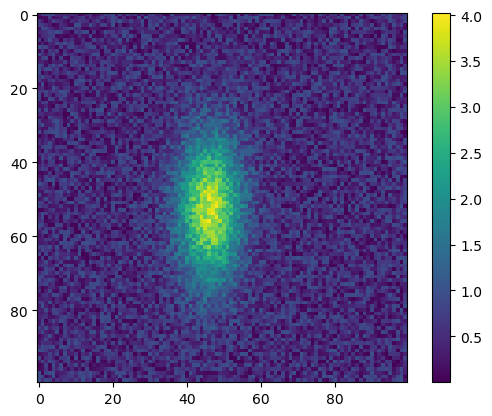

In [99]:
plt.imshow(x[0,0,:,:])
plt.colorbar()

In [9]:
x = batch['input'].cpu().detach().numpy()
p = batch['params'].cpu().detach().numpy()
print('input', x.shape)
print('params', p.shape)

def f(i):
    # print(p[i,0])
    plt.imshow(x[i,0,:,:])
    plt.colorbar()
    plt.xticks(ticks = np.linspace(0,99,11),labels = np.linspace(0,10,11))
    plt.yticks(ticks = np.linspace(0,99,11),labels = np.linspace(0,10,11))
    plt.scatter(p[i,0,0,0]*10,p[i,0,1,0]*10,c='r',marker='x') # plot means
    plt.show()
    
interact(f,i=(0,batch_size-1))

input (32, 1, 100, 100)
params (32, 1, 2, 4, 1)


interactive(children=(IntSlider(value=15, description='i', max=31), Output()), _dom_classes=('widget-interact'…

<function __main__.f(i)>

In [10]:
batch['input'].shape

torch.Size([32, 1, 100, 100])

# try fitting with scipy

In [100]:
from scipy import optimize

def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-x)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-y)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

In [65]:
%%timeit
fits=[]
for sample in x:
    fits.append(fitgaussian(sample[0,:,:]))

382 ms ± 5.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [101]:
fits=[]
for sample in x:
    fits.append(fitgaussian(sample[0,:,:]))

In [102]:
fitpoints = fits[0]
x_,y_ = np.meshgrid(np.linspace(0,99,100),np.linspace(0,99,100))
imgs = []
for fitpoints in fits:
    fitfunc = gaussian(fitpoints[0],fitpoints[1],fitpoints[2],fitpoints[3],fitpoints[4])    
    imgs.append(fitfunc(x_,y_))
# plt.imshow(img)

In [103]:
def f(i):
    plt.figure(figsize=(4,4))
    plt.imshow(x[i,0,:,:])
    plt.colorbar()
    plt.suptitle(f'noise = 3')
    plt.xticks(ticks = np.linspace(0,99,11),labels = np.linspace(0,10,11))
    plt.yticks(ticks = np.linspace(0,99,11),labels = np.linspace(0,10,11))
    plt.scatter(fits[i][2],fits[i][1],c='white',marker='x',label='pred') # plot means
    plt.scatter(p[i,0,0,0]*10,p[i,0,1,0]*10,c='r',marker='x',label='true') # plot means
    plt.show()

    plt.figure(figsize=(4,4))
    plt.imshow(true[i,0,:,:])
    plt.colorbar()
    plt.suptitle(f'true noiseless')
    plt.xticks(ticks = np.linspace(0,99,11),labels = np.linspace(0,10,11))
    plt.yticks(ticks = np.linspace(0,99,11),labels = np.linspace(0,10,11))
    plt.scatter(fits[i][2],fits[i][1],c='white',marker='x',label='pred') # plot means
    plt.scatter(p[i,0,0,0]*10,p[i,0,1,0]*10,c='r',marker='x',label='true') # plot means
    plt.show()

    plt.figure(figsize=(4,4))
    plt.imshow(imgs[i].T)
    plt.colorbar()
    plt.suptitle(f'Scipy')
    plt.xticks(ticks = np.linspace(0,99,11),labels = np.linspace(0,10,11))
    plt.yticks(ticks = np.linspace(0,99,11),labels = np.linspace(0,10,11))
    plt.scatter(fits[i][2],fits[i][1],c='white',marker='x',label='pred') # plot means
    plt.scatter(p[i,0,0,0]*10,p[i,0,1,0]*10,c='r',marker='x',label='true') # plot means
    plt.show()
    
interact(f,i=(0,batch_size-1))

interactive(children=(IntSlider(value=15, description='i', max=31), Output()), _dom_classes=('widget-interact'…

<function __main__.f(i)>

# Training

## define model
* there used to be an earlier Linear layer (Underfit) concatanated with a linear layer from deeper in the model(Overfit, or well fit).
* This did not work as well in 2D. Perhaps add a separate module, then combine for loss function.

In [20]:
import torch.nn as nn
import torch

class DensePhysLarger(nn.Module):
    def __init__(self,
                 x_vector,
                 model,
                 dense_params=3,
                 verbose=False,
                 device = 'cuda',
                 num_channels=1,
                 **kwargs):

        """
        Args:
            x_vector: The vector of values for x
            model: the empirical function to fit
            dense_params: number of output parameters to the model
            verbose: sets if the model is verbose
            device: device where the model will run
            num_channels: number of channels in the input
        """

        super().__init__()
        self.dense_params = dense_params
        self.x_vector = x_vector
        self.verbose = verbose
        self.num_channels = num_channels
        self.device = device
        self.model_params = kwargs.get('model_params')
        self.model = model #(self.x_vector, size=(num_channels, dense_params // self.model_params))
        self.sigmoid = nn.Sigmoid()
        n = 4


        if torch.cuda.is_available():
            self.cuda()

        # Input block of 1d convolution
        self.hidden_x1 = nn.Sequential(
            nn.Conv2d(self.num_channels, 8*n, kernel_size=7), nn.SELU(),
            nn.Conv2d(8*n, 6*n, kernel_size=7), nn.SELU(),
            nn.Conv2d(6*n, 4, kernel_size=5), nn.SELU(),
            nn.Conv2d(4, 4, kernel_size=5), nn.SELU(),
            nn.Conv2d(4, 4, kernel_size=3), nn.SELU(),
            nn.Conv2d(4, 4, kernel_size=3), nn.SELU(),
        )

        self.hidden_x1_shape = self.hidden_x1( torch.zeros(1, 
                                                            self.num_channels,
                                                            self.x_vector.shape[0],
                                                            self.x_vector.shape[0],
                                                            )).shape
        # bp()
        #fully connected block
        self.hidden_xfc = nn.Sequential(
            nn.Linear(self.hidden_x1_shape[1] * self.hidden_x1_shape[2]*self.hidden_x1_shape[3], 200), nn.SELU(),
            nn.Linear(200,100), nn.SELU(),
        )  # out of size 100
        
        self.hidden_xfc_shape = self.hidden_xfc(torch.zeros(1,
                                                            self.hidden_x1_shape[1]*self.hidden_x1_shape[2]*self.hidden_x1_shape[3])).shape
        # bp()
        # 2nd block of 1d-conv layers
        self.hidden_x2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(4, 4, kernel_size=5), nn.SELU(),
            nn.Conv2d(4, 4, kernel_size=5), nn.SELU(),
            nn.Conv2d(4, 4, kernel_size=3), nn.SELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(4, 4, kernel_size=3), nn.SELU(),
            nn.Conv2d(4, 4, kernel_size=3), nn.SELU(),
            nn.Conv2d(4, 4, kernel_size=3), nn.SELU(),
        )
        
        self.hidden_x2_shape = self.hidden_x2(torch.zeros(self.hidden_xfc_shape[0],
                                                          self.hidden_x1_shape[1],
                                                          self.hidden_x1_shape[2],
                                                          self.hidden_x1_shape[3]
                                                         )).shape
        
        # 3nd block of 1d-conv layers
        self.hidden_x3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(1, 4*n, kernel_size=3), nn.SELU(),
            nn.Conv2d(4*n, 4*n, kernel_size=3), nn.SELU(),
            nn.Conv2d(4*n, 4*n, kernel_size=3), nn.SELU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(4*n, 2*n, kernel_size=3), nn.SELU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(2*n, 2, kernel_size=3), nn.SELU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(2, 1, kernel_size=3), nn.SELU(),
            nn.AvgPool2d(kernel_size=2),
        )
        
        self.hidden_x3_shape = self.hidden_x3(torch.zeros(self.hidden_xfc_shape[0],
                                                          1,
                                                        self.hidden_x2_shape[1]*self.hidden_x2_shape[2]*self.hidden_x2_shape[3],
                                                        self.hidden_x2_shape[1]*self.hidden_x2_shape[2]*self.hidden_x2_shape[3]
                                                         )).shape
        # bp()
        # Flatten layer
        self.flatten_layer = nn.Flatten()
        # bp()
        # Final embedding block - Output 4 values - linear
        in_shape = self.hidden_x2_shape[1] * self.hidden_x2_shape[2] * self.hidden_x2_shape[3]
        self.hidden_embedding = nn.Sequential(
            nn.Linear(in_shape 
                      ,100),
            nn.SELU(),
            nn.Linear(100, 50),
            nn.SELU(),
            nn.Linear(50, self.dense_params)
        )
        # bp()
    def forward(self, x, n=-1):
        # x = x['input'].type(torch.FloatTensor).to(self.device)
        # bp()
        x = self.hidden_x1(x)
        # bp()
        xfc = torch.reshape(x, (x.shape[0], -1))  # batch size, features
        # bp()
        xfc = self.hidden_xfc(xfc)
        # bp()
        x = self.hidden_x2(x)
        # bp()
        # x=self.flatten_layer(x)
        # bp()
        # x=x.unsqueeze(1).repeat(1,x.shape[-1],1)
        # # bp()
        # # print(x.shape)
        # x = self.hidden_x3(x.unsqueeze(1))
        # bp()
        # print(x.shape)
        cnn_flat = self.flatten_layer(x)
        # bp()
        # encoded = torch.cat((cnn_flat, xfc), 1)  # merge dense and 1d conv layers
        # print("encoded", encoded.shape)    
            
        embedding = self.hidden_embedding(cnn_flat)  # output is 4 parameters

        # print("embedding", embedding.shape)    
        
        embedding = torch.reshape(embedding, (embedding.shape[0], 2, -1,4))
        embedding = embedding.transpose(2,3)
        sh = embedding.shape[-1]
        # bp()
        # embedding[:,:,0,:] = self.sigmoid(embedding[:,:,0,:]) #
        embedding[:,:,0,:] = embedding[:,:,0,:] * self.model.mean_sd.repeat(sh,1).T.to(self.device) + self.model.mean_mean.repeat(sh,1).T.to(self.device)
        # embedding[:,:,1,:] = self.sigmoid(embedding[:,:,1,:]) # 
        embedding[:,:,1,:] = embedding[:,:,1,:] * self.model.sd_sd.repeat(sh,1).T.to(self.device) + self.model.sd_mean.repeat(sh,1).T.to(self.device)
        # embedding[:,:,2,:] = self.sigmoid(embedding[:,:,2,:]) # 
        embedding[:,:,2,:] = embedding[:,:,2,:] * self.model.amp_sd.repeat(sh,1).T.to(self.device) + self.model.amp_mean.repeat(sh,1).T.to(self.device)
        embedding[:,:,3,:] = self.sigmoid(embedding[:,:,3,:]) #* self.model.fraction_sd + self.model.fraction_mean
        # bp()
        # embedding = torch.transpose(embedding,2,3)
        embedding = embedding.unsqueeze(1)
        embedding = torch.abs(embedding)
        self.embed = embedding
        # bp()
        out = self.model.compute(embedding, device = self.device)
        # bp()
        # out = torch.atleast_3d(out) #makes out 3 demensional view of each 0 dimensions in input out
        
        return out.to(self.device), embedding.to(self.device)

In [21]:
def save_model(checkpoint,foldername,epoch,loss):
    '''
    Save pkl file to a given folder and adds date and epoch
    Args:
        checkpoint (str): pkl file to save
        foldername (str): folder to save file in 
        epoch (int): 
    '''
    today = date.today()
    save_date=today.strftime('(%Y-%m-%d)')
    # make_folder(foldername)
    torch.save(checkpoint, f'./{foldername}/{save_date}_epoch:{epoch:05d}_loss:{loss:.5f}_weights.pkl')

## Initialize model

In [22]:
constructor = PseudoVoigt_2D( mean=[[2,8],[5,7]], 
                              sd=[[.5,2],[1,3]],
                              amp=[[2,6],[2,6]], 
                              fraction = [[0,0],[0,0]],
                            x_vector = torch.linspace(0,10,100), size=(1,1))

In [23]:
# %%timeit
# takes ab 5 s to initialize model
# x_vector = torch.linspace(0,10,100) #evenly distributes values in a tensor from 1 to 10 with 100 steps
loss_func = torch.nn.MSELoss()
model = DensePhysLarger(x_vector, constructor, dense_params=4*2, model_params=4, verbose=True)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

if torch.cuda.is_available():
    model.cuda()


## train

In [24]:
start,epochs=0,50
for epoch in range(start,epochs):
    train_loss = 0.
    total_num = 0
    model.train()
    
    for batch in tqdm(dataloader):
        # train_batch = torch.FloatTensor(batch['input'].transpose(1,2))
        train_batch = batch['input'].type(torch.FloatTensor).cuda()
        pred, _ = model(train_batch.cuda())
        # bp()
        optimizer.zero_grad()
        loss = loss_func(train_batch, pred)
        loss.backward(create_graph=False)
        train_loss += loss.item() * pred.shape[0]
        total_num += pred.shape[0]
        optimizer.step()
        
    # bp()
    train_loss /= total_num
    checkpoint = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        # 'params': parameters_dict,
        'train_loss': train_loss,
        # 'seed': seed
    }
    
    if (epoch % 5 == 0):
        save_model(checkpoint,'2D_results_1pk',epoch,train_loss)
        
    print(f"epoch : {epoch}/{epochs}, recon loss = {train_loss:.8f}")
    # print("--- %s seconds ---" % (time.time() - start_time))

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.52it/s]


epoch : 0/50, recon loss = 0.99007815


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:53<00:00, 18.67it/s]


epoch : 1/50, recon loss = 0.65793680


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:53<00:00, 18.68it/s]


epoch : 2/50, recon loss = 0.62897426


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:53<00:00, 18.69it/s]


epoch : 3/50, recon loss = 0.62000566


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:53<00:00, 18.66it/s]


epoch : 4/50, recon loss = 0.60318343


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:53<00:00, 18.75it/s]


epoch : 5/50, recon loss = 0.58768340


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:53<00:00, 18.71it/s]


epoch : 6/50, recon loss = 0.56633416


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.42it/s]


epoch : 7/50, recon loss = 0.55698856


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:55<00:00, 18.17it/s]


epoch : 8/50, recon loss = 0.55022117


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.51it/s]


epoch : 9/50, recon loss = 0.55261087


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:53<00:00, 18.54it/s]


epoch : 10/50, recon loss = 0.55259923


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:56<00:00, 17.78it/s]


epoch : 11/50, recon loss = 0.54860137


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.30it/s]


epoch : 12/50, recon loss = 0.54848931


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.26it/s]


epoch : 13/50, recon loss = 0.54236756


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:55<00:00, 18.00it/s]


epoch : 14/50, recon loss = 0.54013789


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.25it/s]


epoch : 15/50, recon loss = 0.54098909


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.35it/s]


epoch : 16/50, recon loss = 0.54222075


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.26it/s]


epoch : 17/50, recon loss = 0.53607098


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.25it/s]


epoch : 18/50, recon loss = 0.53575672


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:55<00:00, 18.01it/s]


epoch : 19/50, recon loss = 0.53501466


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:53<00:00, 18.77it/s]


epoch : 20/50, recon loss = 0.53645068


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:53<00:00, 18.66it/s]


epoch : 21/50, recon loss = 0.53338109


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.50it/s]


epoch : 22/50, recon loss = 0.53825046


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:53<00:00, 18.61it/s]


epoch : 23/50, recon loss = 0.53583045


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:53<00:00, 18.76it/s]


epoch : 24/50, recon loss = 0.53952531


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:52<00:00, 18.88it/s]


epoch : 25/50, recon loss = 0.53457062


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:55<00:00, 18.11it/s]


epoch : 26/50, recon loss = 0.53454412


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.36it/s]


epoch : 27/50, recon loss = 0.53130583


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.29it/s]


epoch : 28/50, recon loss = 0.53138294


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.22it/s]


epoch : 29/50, recon loss = 0.53344032


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:55<00:00, 17.97it/s]


epoch : 30/50, recon loss = 0.53024445


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.40it/s]


epoch : 31/50, recon loss = 0.53183354


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:55<00:00, 18.14it/s]


epoch : 32/50, recon loss = 0.53206133


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.34it/s]


epoch : 33/50, recon loss = 0.53218332


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.36it/s]


epoch : 34/50, recon loss = 0.53277880


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:53<00:00, 18.68it/s]


epoch : 35/50, recon loss = 0.53918783


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:53<00:00, 18.58it/s]


epoch : 36/50, recon loss = 0.53472869


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:55<00:00, 18.04it/s]


epoch : 37/50, recon loss = 0.53397460


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:55<00:00, 17.99it/s]


epoch : 38/50, recon loss = 0.53216946


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.31it/s]


epoch : 39/50, recon loss = 0.53474753


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.39it/s]


epoch : 40/50, recon loss = 0.53347990


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.34it/s]


epoch : 41/50, recon loss = 0.53536811


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:55<00:00, 18.12it/s]


epoch : 42/50, recon loss = 0.53232826


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.42it/s]


epoch : 43/50, recon loss = 0.53462440


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:55<00:00, 17.96it/s]


epoch : 44/50, recon loss = 0.53132197


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:55<00:00, 18.08it/s]


epoch : 45/50, recon loss = 0.52938193


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.32it/s]


epoch : 46/50, recon loss = 0.53486017


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:55<00:00, 18.16it/s]


epoch : 47/50, recon loss = 0.53010732


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.20it/s]


epoch : 48/50, recon loss = 0.53328793


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.25it/s]

epoch : 49/50, recon loss = 0.53385548


# Results

## Load model

In [16]:
file_path = './2D_results_1pk/(2022-12-01)_epoch:00045_loss:0.52938_weights.pkl' # fill with your saved

In [18]:
checkpoint = torch.load(file_path)  

model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer']) 

In [77]:
# # Reload if needed
# dataloader = DataLoader(data_test, batch_size=batch_size,
#                         shuffle=True, num_workers=0)


## display

In [60]:
%%timeit
pred,par = model(batch['input'].type(torch.FloatTensor).cuda())

5.91 ms ± 72.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [98]:
batch = next(iter(dataloader))

x = batch['input'].cpu().detach().numpy()
p = batch['params'].cpu().detach().numpy()
true = constructor.compute(batch['params'])
print('input', x.shape)
print('params', p.shape)

pred,par = model(batch['input'].type(torch.FloatTensor).cuda())
print('outpu: ',pred.shape)
print('parameter: ', par.shape)
x_guess=pred.cpu().detach().numpy()
p_guess=par.cpu().detach().numpy()

def f(i):
    plt.figure(figsize=(4,4))
    plt.imshow(x[i,0,:,:])
    plt.colorbar()
    plt.suptitle(f'noise = 3')
    plt.xticks(ticks = np.linspace(0,99,11),labels = np.linspace(0,10,11).astype(int))
    plt.yticks(ticks = np.linspace(0,99,11),labels = np.linspace(0,10,11).astype(int))
    plt.scatter(p_guess[i,0,0,0]*10,p_guess[i,0,1,0]*10,c='white',marker='x',label='pred') # plot means
    plt.scatter(p[i,0,0,0]*10,p[i,0,1,0]*10,c='r',marker='x',label='true') # plot means
    plt.show()
    
    plt.figure(figsize=(4,4))
    plt.imshow(true[i,0,:,:])
    plt.colorbar()
    plt.suptitle(f'true noiseless')
    plt.xticks(ticks = np.linspace(0,99,11),labels = np.linspace(0,10,11).astype(int))
    plt.yticks(ticks = np.linspace(0,99,11),labels = np.linspace(0,10,11).astype(int))
    plt.scatter(p_guess[i,0,0,0]*10,p_guess[i,0,1,0]*10,c='white',marker='x',label='pred') # plot means
    plt.scatter(p[i,0,0,0]*10,p[i,0,1,0]*10,c='r',marker='x',label='true') # plot means
    plt.show()
    
    plt.figure(figsize=(4,4))
    plt.imshow(x_guess[i,0,:,:])
    plt.colorbar()
    plt.suptitle(f'output spectrum and predicted means')
    plt.xticks(ticks = np.linspace(0,99,11),labels = np.linspace(0,10,11).astype(int))
    plt.yticks(ticks = np.linspace(0,99,11),labels = np.linspace(0,10,11).astype(int))
    plt.scatter(p_guess[i,0,0,0]*10,p_guess[i,0,1,0]*10,c='white',marker='x',label='pred') # plot means
    plt.scatter(p[i,0,0,0]*10,p[i,0,1,0]*10,c='r',marker='x',label='true') # plot means
    plt.show()
    
interact(f,i=(0,batch_size-1))

input (32, 1, 100, 100)
params (32, 1, 2, 4, 1)
outpu:  torch.Size([32, 1, 100, 100])
parameter:  torch.Size([32, 1, 2, 4, 1])


interactive(children=(IntSlider(value=15, description='i', max=31), Output()), _dom_classes=('widget-interact'…

<function __main__.f(i)>